##Libraries

In [ ]:
import pandas as pd
import numpy as np
#for text pre-processing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
#for model-building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
# bag of words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
#for word embedding
import gensim
from gensim.models import Word2Vec

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Loading the data

In [ ]:
#uploading the data

df_train= pd.read_csv('/content/Train.csv')
df_test=pd.read_csv('/content/Test.csv')
df_test.head()

,Tweet_ID,tweet
0,ID_0095QL4S,"because he was my boyfriend, and if I said no,..."
1,ID_00DREW5O,"lol no, I'm telling you it's not legal. It's l..."
2,ID_00E9F5X9,Somalia's semi-autonomous Puntland region has ...
3,ID_00G9OSKZ,University of Cape Coast students being robbed...
4,ID_00HU96U6,"""Somebody came up behind him and stabbed him i..."


sexual_violence                 32648
Physical_violence                5946
emotional_violence                651
economic_violence                 217
Harmful_Traditional_practice      188
Name: type, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


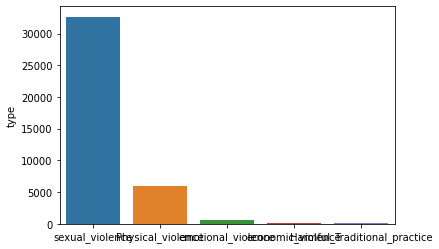

In [ ]:
# view the prediction categories
import seaborn as sns
x=df_train['type'].value_counts()
print(x)
sns.barplot(x.index,x)

## Preprocessing

In [ ]:
# df_train['type'] = df_train['type'].map({'sexual_violence': 0, 'Physical_violence': 1, 'emotional_violence': 2,
#                              'Harmful_Traditional_practice': 3, 'economic_violence': 4})
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df_train['type'] = le.fit_transform(df_train['type'])

In [ ]:
df_train['type'].unique()

array([4, 1, 3, 0, 2])

4    32648
1     5946
3      651
2      217
0      188
Name: type, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


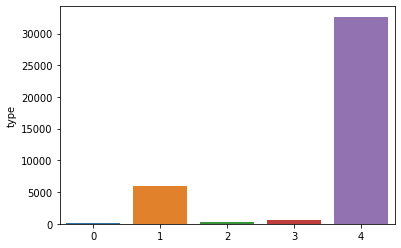

In [ ]:
x=df_train['type'].value_counts()
print(x)
sns.barplot(x.index,x);

In [ ]:
#1. WORD-COUNT
df_train['word_count'] = df_train['tweet'].apply(lambda x: len(str(x).split()))
print(df_train[df_train['type']==0]['word_count'].mean()) #Abuse tweets
print(df_train[df_train['type']==1]['word_count'].mean()) #Non-Disaster tweets
print(df_train[df_train['type']==2]['word_count'].mean()) 
print(df_train[df_train['type']==3]['word_count'].mean()) 
print(df_train[df_train['type']==4]['word_count'].mean()) 
print('***'*30)
#Disaster tweets are more wordy than the non-disaster tweets

#2. CHARACTER-COUNT
df_train['char_count'] = df_train['tweet'].apply(lambda x: len(str(x)))
print(df_train[df_train['type']==0]['char_count'].mean()) #Disaster tweets
print(df_train[df_train['type']==1]['char_count'].mean())
print(df_train[df_train['type']==2]['char_count'].mean())
print(df_train[df_train['type']==3]['char_count'].mean())
print(df_train[df_train['type']==4]['char_count'].mean())
print('***'*30) #Non-Disaster tweets
#Disaster tweets are longer than the non-disaster tweets

#3. UNIQUE WORD-COUNT
df_train['unique_word_count'] = df_train['tweet'].apply(lambda x: len(set(str(x).split())))
print(df_train[df_train['type']==0]['unique_word_count'].mean()) #Disaster tweets
print(df_train[df_train['type']==1]['unique_word_count'].mean()) #Non-Disaster tweets
print(df_train[df_train['type']==2]['unique_word_count'].mean())
print(df_train[df_train['type']==3]['unique_word_count'].mean())
print(df_train[df_train['type']==4]['unique_word_count'].mean())

33.920212765957444
23.301883619239824
40.534562211981566
38.48233486943165
41.74981622151434
******************************************************************************************
191.7659574468085
122.67574840228725
205.38248847926266
202.65284178187403
213.30792085273217
******************************************************************************************
30.22340425531915
21.474100235452404
34.31336405529954
33.78033794162826
36.008208772359716


In [ ]:
df_train.isna().sum()

Tweet_ID             0
tweet                0
type                 0
word_count           0
char_count           0
unique_word_count    0
dtype: int64

In [ ]:
# # PLOTTING WORD-COUNT
# import matplotlib.pyplot as plt

# fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,4))
# train_words=df_train[df_train['type']==1]['tweet']
# ax1.hist(train_words,color='red')
# ax1.set_title('Disaster tweets')
# train_words=df_train[df_train['type']==0]['tweet']
# ax2.hist(train_words,color='green')
# ax2.set_title('Non-disaster tweets')
# fig.suptitle('Words per tweet')
# plt.show()

In [ ]:
#convert to lowercase, strip and remove punctuations
def preprocess(text):
    text = text.lower() 
    text=text.strip()  
    text=re.compile('<.*?>').sub('', text) 
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  
    text = re.sub('\s+', ' ', text)  
    text = re.sub(r'\[[0-9]*\]',' ',text) 
    text=re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) 
    text = re.sub(r'\s+',' ',text) 
    return text

 
# STOPWORD REMOVAL
def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)
#LEMMATIZATION
# Initialize the lemmatizer
wl = WordNetLemmatizer()
 
# This is a helper function to map NTLK position tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
# Tokenize the sentence
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return " ".join(a)

In [ ]:
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
def finalpreprocess(string):
    return lemmatizer(stopword(preprocess(string)))
df_train['clean_text'] = df_train['tweet'].apply(lambda x: finalpreprocess(x))
df_train.head()

,Tweet_ID,tweet,type,word_count,char_count,unique_word_count,clean_text
0,ID_0022DWKP,Had a dream i got raped last night. By a guy i...,4,45,203,40,dream get rap last night guy work actually guy...
1,ID_00395QYM,he thought the word raped means sex and told m...,4,21,100,20,think word rap mean sex tell saw dog rap eacho...
2,ID_003EOSSF,She NOT TALKING TO ME I WAS RAPED BY 2 MEN 1 M...,4,24,104,23,talk rap men molest jail nother charge say word
3,ID_004BBHOD,I was sexually abused for 3 years at age 4 to ...,4,61,280,50,sexually abused year age one believe rap bros ...
4,ID_004F7516,Chessy Prout can do better by telling the trut...,4,52,278,44,chessy prout good tell truth sell owen labrie ...


In [ ]:
# Converting all characters in the message to lower case
# 
df_train['clean_text'] = df_train['clean_text'].map(lambda x: x.lower())

# Removing any punctuation
# 
df_train['clean_text'] = df_train['clean_text'].str.replace('[^\w\s_]', '')

# Removing numbers from strings of speciafied 
# Column, here 'tweet'
df_train['clean_text'] = df_train['clean_text'].str.replace('\d+', '')

df_train.sample(15)

,Tweet_ID,tweet,type,word_count,char_count,unique_word_count,clean_text
19440,ID_HQKEG389,You know the craziest thing abt this rape issu...,4,54,279,45,know crazy thing abt rape issue people talk co...
30329,ID_RM3UQDPJ,Me too! I’ve always hated Trump since the 1970...,4,51,277,47,ive always hat trump since beat rap wife racis...
35199,ID_W1WEVR6C,One detained woman compared her visit to the g...,4,24,134,21,one detain woman compare visit gynecologist ra...
33068,ID_U3C6VI0Z,He is a predator of young girls and raped me. ...,4,41,225,35,predator young girl rap access laptop everythi...
28893,ID_QC056YKK,the older girls used to b weird as shit w me w...,4,57,280,49,old girl use b weird shit w kid n wasnt summer...
34545,ID_VGP3NDHS,"I am responsible for my husband's upkeep, yet ...",1,21,117,21,responsible husband upkeep yet beat estrange w...
23578,ID_LI8S4BEN,Well let me explain a simple tweet to u in lay...,4,48,266,41,well let explain simple tweet u layman term u ...
6714,ID_629GL1J4,"My husband beats, strips me n*ked, woman tells...",1,9,56,9,husband beat strip n ked woman tell court
33172,ID_U6KKTO0S,"How do you know he isn't being paid, maybe qui...",4,38,194,35,know pay maybe quid pro quo tell public father...
24760,ID_MKMU53SA,Biden raped me .actually he is raping me righ...,4,16,84,13,biden rap actually rap right rap million iranian


In [ ]:
df_train['clean_text'] = df_train['clean_text'].astype(str)

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39650 entries, 0 to 39649
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Tweet_ID           39650 non-null  object
 1   tweet              39650 non-null  object
 2   type               39650 non-null  int64 
 3   word_count         39650 non-null  int64 
 4   char_count         39650 non-null  int64 
 5   unique_word_count  39650 non-null  int64 
 6   clean_text         39650 non-null  object
dtypes: int64(4), object(3)
memory usage: 2.1+ MB


In [ ]:

# create Word2vec model
#here words_f should be a list containing words from each document. say 1st row of the list is words from the 1st document/sentence
#length of words_f is number of documents/sentences in your dataset
df_train['clean_text_tok']=[nltk.word_tokenize(i) for i in df_train['clean_text']] #convert preprocessed sentence to tokenized sentence
model = Word2Vec(df_train['clean_text_tok'],min_count=1)  #min_count=1 means word should be present at least across all documents,
#if min_count=2 means if the word is present less than 2 times across all the documents then we shouldn't consider it


w2v = dict(zip(model.wv.index2word, model.wv.syn0))  #combination of word and its vector

#for converting sentence to vectors/numbers from word vectors result by Word2Vec
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(next(iter(word2vec.values())))

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  # Remove the CWD from sys.path while we load stuff.


## Vectorizing

In [ ]:
#SPLITTING THE TRAINING DATASET INTO TRAINING AND VALIDATION
 
# Input: "reviewText", "rating" and "time"
# Target: "log_votes"

X_train, X_val, y_train, y_val = train_test_split(df_train["clean_text"], 
                                                  df_train["type"],
                                                  test_size=0.33,
                                                  shuffle=True)
X_train_tok= [nltk.word_tokenize(i) for i in X_train]  #for word2vec # X_train

X_val_tok= [nltk.word_tokenize(i) for i in X_val]      #for word2vec # X_test

#TF-IDF
# Convert x_train to vector since model can only run on numbers and not words- Fit and transform
#
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train) #tfidf runs on non-tokenized sentences unlike word2vec
#

# Only transform x_test (not fit and transform)
X_val_vectors_tfidf = tfidf_vectorizer.transform(X_val) #Don't fit() your TfidfVectorizer to your test data: it will 
#
#change the word-indexes & weights to match test data. Rather, fit on the training data, then use the same train-data-
#fit model on the test data, to reflect the fact you're analyzing the test data only based on what was learned without 
#it, and the have compatible


#Word2vec
# Fit and transform
#
modelw = MeanEmbeddingVectorizer(w2v)
X_train_vectors_w2v = modelw.transform(X_train_tok)
X_val_vectors_w2v = modelw.transform(X_val_tok)

In [ ]:
lr_tfidf=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
lr_tfidf.fit(X_train_vectors_tfidf, y_train)  #model

from pprint import pprint
pprint(lr_tfidf.get_params)

<bound method BaseEstimator.get_params of LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)>


## Modeling

### Logistic Regression

In [ ]:
#FITTING THE CLASSIFICATION MODEL using Logistic Regression(tf-idf)

lr_tfidf=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
lr_tfidf.fit(X_train_vectors_tfidf, y_train)  #model

#Predict y value for test dataset
y_predict = lr_tfidf.predict(X_val_vectors_tfidf)
y_prob = lr_tfidf.predict_proba(X_val_vectors_tfidf)[:,1]
 

print(classification_report(y_val,y_predict))
print('Confusion Matrix:',confusion_matrix(y_val, y_predict))
 


              precision    recall  f1-score   support

           0       1.00      0.82      0.90        67
           1       0.99      0.99      0.99      1962
           2       0.98      0.81      0.89        75
           3       0.98      0.96      0.97       226
           4       1.00      1.00      1.00     10755

    accuracy                           1.00     13085
   macro avg       0.99      0.92      0.95     13085
weighted avg       1.00      1.00      1.00     13085

Confusion Matrix: [[   55     0     0     0    12]
 [    0  1952     0     0    10]
 [    0     0    61     0    14]
 [    0     0     0   218     8]
 [    0    14     1     5 10735]]


In [ ]:

#Testing it on new dataset with the best model
#df_test=pd.read_csv('test.csv')  #reading the data

#preprocessing
df_test['clean_text'] = df_test['tweet'].apply(lambda x: finalpreprocess(x)) #preprocess the data
X_test=df_test['clean_text'] 

#text to vector
X_vector=tfidf_vectorizer.transform(X_test) #converting X_test to vector
y_predict = lr_tfidf.predict(X_vector)      #use the trained model on X_vector
y_prob = lr_tfidf.predict_proba(X_vector)[:,1]
df_test['predict_prob']= y_prob
df_test['target']= y_predict
print(df_test.head())
final=df_test[['Tweet_ID']].reset_index(drop=True)
final.to_csv('submission.csv')

      Tweet_ID  ... target
0  ID_0095QL4S  ...      4
1  ID_00DREW5O  ...      0
2  ID_00E9F5X9  ...      4
3  ID_00G9OSKZ  ...      4
4  ID_00HU96U6  ...      4

[5 rows x 5 columns]


In [ ]:
attempt1 = df_test.copy(deep=True)

In [ ]:
attempt1.columns
attempt1.drop([ 'tweet', 'clean_text', 'predict_prob',], axis = 1, inplace = True)

### Solving Class Imbalance

In [ ]:
# Import the libraries
from sklearn.datasets import make_classification

from imblearn.over_sampling import SVMSMOTE
lr_tfidf = SVMSMOTE(random_state = 101)

# Choosing a sample
X_oversample_svm, y_oversample_svm = make_classification(n_samples=10000, n_features=2,
                                                         n_redundant=0, n_clusters_per_class=1,
                                                         weights=[0.99], flip_y=0, random_state=101)

# Perform Logistic Regression
X_oversample_svm, y_oversample_svm = lr_tfidf.fit_resample(X_train_vectors_tfidf, y_train)
classifier_svm = LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
classifier_svm.fit(X_oversample_svm, y_oversample_svm)

#Predict y value for test dataset
y_predict = classifier_svm.predict(X_val_vectors_tfidf)
y_prob = classifier_svm.predict_proba(X_val_vectors_tfidf)[:,1]
 

print(classification_report(y_val, y_predict))
print('Confusion Matrix:',confusion_matrix(y_val, y_predict))
 

#print(classification_report(y_test, classifier_svm.predict(X_test)))

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/loca

              precision    recall  f1-score   support

           0       0.99      0.99      0.99        67
           1       0.99      1.00      0.99      1962
           2       0.96      1.00      0.98        75
           3       0.97      1.00      0.98       226
           4       1.00      1.00      1.00     10755

    accuracy                           1.00     13085
   macro avg       0.98      1.00      0.99     13085
weighted avg       1.00      1.00      1.00     13085

Confusion Matrix: [[   66     0     0     0     1]
 [    0  1959     1     0     2]
 [    0     0    75     0     0]
 [    0     0     0   225     1]
 [    1    17     2     7 10728]]


### Data Processing After Solving Class Imbalance

In [ ]:
#Testing it on new dataset with the best model
#df_test=pd.read_csv('test.csv')  #reading the data

#preprocessing
df_test['clean_text'] = df_test['tweet'].apply(lambda x: finalpreprocess(x)) #preprocess the data
X_test=df_test['clean_text'] 

#text to vector
X_vector_imb = tfidf_vectorizer.transform(X_test) #converting X_test to vector
y_predict_imb = classifier_svm.predict(X_vector)      #use the trained model on X_vector
y_prob = classifier_svm.predict_proba(X_vector_imb)[:,1]
df_test['predict_prob']= y_prob
df_test['target']= y_predict_imb
print(df_test.head())


      Tweet_ID  ... target
0  ID_0095QL4S  ...      4
1  ID_00DREW5O  ...      0
2  ID_00E9F5X9  ...      0
3  ID_00G9OSKZ  ...      4
4  ID_00HU96U6  ...      4

[5 rows x 5 columns]


In [ ]:
dff2 = df_test.copy()
dff2.drop([ 'tweet', 'clean_text'], axis = 1, inplace = True)
dff2.to_csv('Support_Vector_Model.csv')
dff2

,Tweet_ID,predict_prob,target
0,ID_0095QL4S,0.000951,4
1,ID_00DREW5O,0.007645,0
2,ID_00E9F5X9,0.001219,0
3,ID_00G9OSKZ,0.002683,4
4,ID_00HU96U6,0.032311,4
...,...,...,...
15576,ID_ZZR1D21T,0.000056,0
15577,ID_ZZSQF54Y,0.000021,4
15578,ID_ZZTN5126,0.000067,4
15579,ID_ZZWS0XZZ,0.010406,4


In [ ]:
dff2.head()

,Tweet_ID,predict_prob,target
0,ID_0095QL4S,0.000951,4
1,ID_00DREW5O,0.007645,0
2,ID_00E9F5X9,0.001219,0
3,ID_00G9OSKZ,0.002683,4
4,ID_00HU96U6,0.032311,4


In [ ]:
dff3 = dff2.copy(deep=True)
# overwriting column with replaced value of age
dff3["target"] = dff3["target"].replace(4, "sexual_violence")
dff3["target"] = dff3["target"].replace(1, "Physical_violence")
dff3["target"] = dff3["target"].replace(3, "emotional_violence")
dff3["target"] = dff3["target"].replace(2, "economic_violence")
dff3["target"] = dff3["target"].replace(0, "Harmful_Traditional_practice")
dff3.head()

,Tweet_ID,predict_prob,target
0,ID_0095QL4S,0.000951,sexual_violence
1,ID_00DREW5O,0.007645,Harmful_Traditional_practice
2,ID_00E9F5X9,0.001219,Harmful_Traditional_practice
3,ID_00G9OSKZ,0.002683,sexual_violence
4,ID_00HU96U6,0.032311,sexual_violence


In [ ]:
dff3.to_csv('SVM_updated.csv')

### Support Vector Machine

#### Linear

In [ ]:
# Import Suport Vector Classifier module from svm library. We'll use SVC to model our data
from sklearn.svm import SVC,LinearSVC
from sklearn.model_selection import train_test_split
# Import scikit-learn metrics module for accuracy calculation
from sklearn.metrics import  accuracy_score
from sklearn.metrics import confusion_matrix

In [ ]:
# Fit the model
svm = SVC(kernel= 'linear')
svm.fit(X_train_vectors_tfidf, y_train)

y_pred_svm = svm.predict(X_val_vectors_tfidf)

In [ ]:
model_accuracy = accuracy_score(y_val, y_pred_svm)
print(model_accuracy)

# We've gotten a classification rate of 95.61%. This is a pretty good accuracy score 

# For further evaluation you can also check the confusion matrix
confusion_matrix = confusion_matrix(y_val, y_pred_svm)
confusion_matrix

0.996178830722201


array([[   61,     0,     0,     0,     6],
       [    1,  1955,     1,     0,     5],
       [    0,     0,    69,     0,     6],
       [    0,     0,     0,   222,     4],
       [    0,    17,     1,     9, 10728]])

In [ ]:
df_test['clean_text'] = df_test['tweet'].apply(lambda x: finalpreprocess(x)) #preprocess the data
X_test=df_test['clean_text'] 


In [ ]:
#text to vector
X_vector=tfidf_vectorizer.transform(X_test) #converting X_test to vector
y_predict_svm = svm.predict(X_vector)      #use the trained model on X_vector
#y_prob = svm.predict_proba(X_vector)[:,1]
#df_test['predict_prob']= y_prob
y_predict_svm = le.inverse_transform(y_predict_svm)
#final.to_csv('SVM.csv')

In [ ]:
df_test['target']= y_predict_svm
print(df_test.head())
#final=df_test[['Tweet_ID']].reset_index(drop=True)

      Tweet_ID  ...                        target
0  ID_0095QL4S  ...               sexual_violence
1  ID_00DREW5O  ...  Harmful_Traditional_practice
2  ID_00E9F5X9  ...               sexual_violence
3  ID_00G9OSKZ  ...               sexual_violence
4  ID_00HU96U6  ...               sexual_violence

[5 rows x 5 columns]


In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15581 entries, 0 to 15580
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Tweet_ID      15581 non-null  object 
 1   tweet         15581 non-null  object 
 2   clean_text    15581 non-null  object 
 3   predict_prob  15581 non-null  float64
 4   target        15581 non-null  object 
dtypes: float64(1), object(4)
memory usage: 608.8+ KB


In [ ]:
dff = df_test.copy()
dff.drop([ 'tweet', 'clean_text'], axis = 1, inplace = True)
dff.to_csv('Support_Vector_Model.csv')

In [ ]:
attempt1 = dff.to_csv('Support_Vector_Model_new.csv')

In [ ]:
attempt1

In [ ]:
from sklearn.naive_bayes import MultinomialNB as mn

mn = mn()

model = mn.fit(X_train_vectors_tfidf, y_train)
y_p = model.predict(X_val_vectors_tfidf)

from sklearn.metrics import accuracy_score

accuracy_score(y_p, y_val)

0.8850592281238059

In [ ]:
X_val_vectors_tfidf

<13085x25654 sparse matrix of type '<class 'numpy.float64'>'
	with 215922 stored elements in Compressed Sparse Row format>

In [ ]:
#FITTING THE CLASSIFICATION MODEL using Naive Bayes(tf-idf)
#It's a probabilistic classifier that makes use of Bayes' Theorem, a rule that uses probability to make predictions based on prior knowledge of conditions that might be related. This algorithm is the most suitable for such large dataset as it considers each feature independently, calculates the probability of each category, and then predicts the category with the highest probability.

nb_tfidf = MultinomialNB()
nb_tfidf.fit(X_train_vectors_tfidf, y_train)  #model

#Predict y value for test dataset
y_predict = nb_tfidf.predict(X_val_vectors_tfidf)
y_prob = nb_tfidf.predict_proba(X_val_vectors_tfidf)[:,1]
 

print(classification_report(y_val,y_predict))
#print('Confusion Matrix:',confusion_matrix(y_val, y_predict))
 
#fpr, tpr, thresholds = roc_curve(y_val, y_prob)
#roc_auc = auc(fpr, tpr)
#print('AUC:', roc_auc)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        67
           1       1.00      0.42      0.59      1962
           2       0.00      0.00      0.00        75
           3       1.00      0.03      0.06       226
           4       0.88      1.00      0.93     10755

    accuracy                           0.89     13085
   macro avg       0.58      0.29      0.32     13085
weighted avg       0.89      0.89      0.86     13085



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Gradient boost

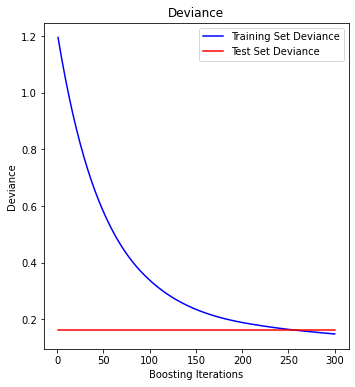

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

# First create a copy of the original dataframe
#gbtrees_df = data_df.copy(deep=True)

#getting the matrix of features x
#X = gbtrees_df.drop('status', axis = 1)
#y = gbtrees_df['status']

#encoding the categroical features in y 
#from sklearn.preprocessing import LabelEncoder
#le = LabelEncoder()
#y = le.fit_transform(y)

#Separate Target Variable and Predictor Variables
#TargetVariable = 'status'
#Predictors = ['age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI', 'TBG']
#X = gbtrees_df[Predictors].values
#y = encoding_df[TargetVariable].values

# Splitting into training set and test set 
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

##
from matplotlib import pyplot as plt

from sklearn.ensemble import GradientBoostingRegressor
target_number_of_trees = 300

boost = GradientBoostingRegressor(n_estimators=target_number_of_trees, learning_rate=0.01, max_depth=1)
boost = boost.fit(X_train_vectors_tfidf, y_train)

y_pred_boost = boost.predict(X_val_vectors_tfidf)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
# the train_score_ variable is a list that records the deviance of the model for any given number of trees. gbr.train_score_[0] is the deviance when we only had the initial tree, whereas
# gbr.train_score_[100] is the deviance by the time we have created 100 trees.
# This is plotted against a simple list that goes from 1 to our target number of trees.
plt.plot(np.arange(target_number_of_trees) + 1, boost.train_score_, 'b-',
         label='Training Set Deviance')

# We also want to see how well we could handle the test set each time. 
# The staged_predict function takes an X, and returns a list of the predictions for X at various stages of the training: What did we pick when we had 1 tree, 2 trees, 3 trees, etc.
# We will compare our predictions at each stage against the test data, and compute the deviance
test_score = np.zeros((target_number_of_trees,), dtype=np.float64) # this is just a list of 0s

for i, y_pred in enumerate(boost.staged_predict(X_vector)): 
    # For each prediction, compute the loss function comparing the actual data with your prediction at a given stage of training
    test_score[i] = boost.loss_(y_val, y_pred_boost)
    
plt.plot(np.arange(target_number_of_trees) + 1, test_score, 'r-',
         label='Test Set Deviance')

plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')
plt.show()